# Load Libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install torchaudio
!pip install pydub

     |████████████████████████████████| 1.9 MB 4.1 MB/s 


In [ ]:
import torch
from torch import nn
from torch._C import device
from torch.nn.modules.activation import ReLU
from torch.nn.modules.linear import Linear
from torch.utils import data
from torch.utils.data import DataLoader, TensorDataset
import torchvision
from torchvision import datasets
from sklearn import preprocessing
from torch import Tensor
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix, classification_report
from torchvision.transforms import ToTensor
from sklearn.model_selection import train_test_split
import torchaudio as ta
import numpy as np
import scipy
from scipy import misc
import glob
import random
import math
from PIL import Image
import os
from pydub import AudioSegment
from collections import defaultdict
import matplotlib.pyplot as plt
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
import torch.nn.functional as F

# Check for GPU availability

In [ ]:
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"
print(f"Using {device} device")

Using cuda device


# Genres definition

In [ ]:
genres = 'blues classical country disco jazz pop hiphop metal reggae rock'
genres = genres.split()

## Creating folders

In [ ]:
os.makedirs('/content/drive/MyDrive/team_project/gtzan/audio1sec')
os.makedirs('/content/drive/MyDrive/team_project/gtzan/audio3sec')
os.makedirs('/content/drive/MyDrive/team_project/gtzan/audio5sec')
os.makedirs('/content/drive/MyDrive/team_project/gtzan/audio10sec')


os.makedirs('/content/drive/MyDrive/team_project/gtzan/audio1sec/train')
os.makedirs('/content/drive/MyDrive/team_project/gtzan/audio1sec/test')
os.makedirs('/content/drive/MyDrive/team_project/gtzan/audio1sec/val')

os.makedirs('/content/drive/MyDrive/team_project/gtzan/audio3sec/train')
os.makedirs('/content/drive/MyDrive/team_project/gtzan/audio3sec/test')
os.makedirs('/content/drive/MyDrive/team_project/gtzan/audio3sec/val')

os.makedirs('/content/drive/MyDrive/team_project/gtzan/audio5sec/train')
os.makedirs('/content/drive/MyDrive/team_project/gtzan/audio5sec/test')
os.makedirs('/content/drive/MyDrive/team_project/gtzan/audio5sec/val')

os.makedirs('/content/drive/MyDrive/team_project/gtzan/audio10sec/train')
os.makedirs('/content/drive/MyDrive/team_project/gtzan/audio10sec/test')
os.makedirs('/content/drive/MyDrive/team_project/gtzan/audio10sec/val')

for g in genres:

  path_train = os.path.join('/content/drive/MyDrive/team_project/gtzan/audio1sec/train',f'{g}')
  path_test = os.path.join('/content/drive/MyDrive/team_project/gtzan/audio1sec/test',f'{g}')
  path_val = os.path.join('/content/drive/MyDrive/team_project/gtzan/audio1sec/val',f'{g}')
  os. makedirs(path_train)
  os. makedirs(path_test)
  os. makedirs(path_val)

  path_train = os.path.join('/content/drive/MyDrive/team_project/gtzan/audio3sec/train',f'{g}')
  path_test = os.path.join('/content/drive/MyDrive/team_project/gtzan/audio3sec/test',f'{g}')
  path_val = os.path.join('/content/drive/MyDrive/team_project/gtzan/audio3sec/val',f'{g}')
  os. makedirs(path_train)
  os. makedirs(path_test)
  os. makedirs(path_val)

  path_train = os.path.join('/content/drive/MyDrive/team_project/gtzan/audio5sec/train',f'{g}')
  path_test = os.path.join('/content/drive/MyDrive/team_project/gtzan/audio5sec/test',f'{g}')
  path_val = os.path.join('/content/drive/MyDrive/team_project/gtzan/audio5sec/val',f'{g}')
  os. makedirs(path_train)
  os. makedirs(path_test)
  os. makedirs(path_val)

  path_train = os.path.join('/content/drive/MyDrive/team_project/gtzan/audio10sec/train',f'{g}')
  path_test = os.path.join('/content/drive/MyDrive/team_project/gtzan/audio10sec/test',f'{g}')
  path_val = os.path.join('/content/drive/MyDrive/team_project/gtzan/audio10sec/val',f'{g}')
  os. makedirs(path_train)
  os. makedirs(path_test)
  os. makedirs(path_val)

## Time Warping function

In [ ]:
def sparse_image_warp(img_tensor,
                      source_control_point_locations,
                      dest_control_point_locations,
                      interpolation_order=2,
                      regularization_weight=0.0,
                      num_boundaries_points=0):
    device = img_tensor.device
    control_point_flows = (dest_control_point_locations - source_control_point_locations)   
    
#     clamp_boundaries = num_boundary_points > 0
#     boundary_points_per_edge = num_boundary_points - 1
    batch_size, image_height, image_width = img_tensor.shape
    flattened_grid_locations = get_flat_grid_locations(image_height, image_width, device)

    # IGNORED FOR OUR BASIC VERSION...
#     flattened_grid_locations = constant_op.constant(
#         _expand_to_minibatch(flattened_grid_locations, batch_size), image.dtype)

#     if clamp_boundaries:
#       (dest_control_point_locations,
#        control_point_flows) = _add_zero_flow_controls_at_boundary(
#            dest_control_point_locations, control_point_flows, image_height,
#            image_width, boundary_points_per_edge)

    flattened_flows = interpolate_spline(
        dest_control_point_locations,
        control_point_flows,
        flattened_grid_locations,
        interpolation_order,
        regularization_weight)

    dense_flows = create_dense_flows(flattened_flows, batch_size, image_height, image_width)

    warped_image = dense_image_warp(img_tensor, dense_flows)

    return warped_image, dense_flows


def get_grid_locations(image_height, image_width, device):
    y_range = torch.linspace(0, image_height - 1, image_height, device=device)
    x_range = torch.linspace(0, image_width - 1, image_width, device=device)
    y_grid, x_grid = torch.meshgrid(y_range, x_range)
    return torch.stack((y_grid, x_grid), -1)

def flatten_grid_locations(grid_locations, image_height, image_width):
    return torch.reshape(grid_locations, [image_height * image_width, 2])

def create_dense_flows(flattened_flows, batch_size, image_height, image_width):
    # possibly .view
    return torch.reshape(flattened_flows, [batch_size, image_height, image_width, 2])

def get_flat_grid_locations(image_height, image_width, device):
    y_range = torch.linspace(0, image_height - 1, image_height, device=device)
    x_range = torch.linspace(0, image_width - 1, image_width, device=device)
    y_grid, x_grid = torch.meshgrid(y_range, x_range)
    return torch.stack((y_grid, x_grid), -1).reshape([image_height * image_width, 2])

def create_dense_flows(flattened_flows, batch_size, image_height, image_width):
    # possibly .view
    return torch.reshape(flattened_flows, [batch_size, image_height, image_width, 2])

def interpolate_spline(train_points, train_values, query_points, order, regularization_weight=0.0,):
    # First, fit the spline to the observed data.
    w, v = solve_interpolation(train_points, train_values, order, regularization_weight)
    # Then, evaluate the spline at the query locations.
    query_values = apply_interpolation(query_points, train_points, w, v, order)

    return query_values

def solve_interpolation(train_points, train_values, order, regularization_weight):
    device = train_points.device
    b, n, d = train_points.shape
    k = train_values.shape[-1]

    # First, rename variables so that the notation (c, f, w, v, A, B, etc.)
    # follows https://en.wikipedia.org/wiki/Polyharmonic_spline.
    # To account for python style guidelines we use
    # matrix_a for A and matrix_b for B.
    
    c = train_points
    f = train_values.float()
    
    matrix_a = phi(cross_squared_distance_matrix(c,c), order).unsqueeze(0)  # [b, n, n]
#     if regularization_weight > 0:
#         batch_identity_matrix = array_ops.expand_dims(
#           linalg_ops.eye(n, dtype=c.dtype), 0)
#         matrix_a += regularization_weight * batch_identity_matrix

    # Append ones to the feature values for the bias term in the linear model.
    ones = torch.ones(1, dtype=train_points.dtype, device=device).view([-1, 1, 1])
    matrix_b = torch.cat((c, ones), 2).float()  # [b, n, d + 1]

    # [b, n + d + 1, n]
    left_block = torch.cat((matrix_a, torch.transpose(matrix_b, 2, 1)), 1)

    num_b_cols = matrix_b.shape[2]  # d + 1

    # In Tensorflow, zeros are used here. Pytorch solve fails with zeros for some reason we don't understand.
    # So instead we use very tiny randn values (variance of one, zero mean) on one side of our multiplication.
    lhs_zeros = torch.randn((b, num_b_cols, num_b_cols), device=device) / 1e10
    right_block = torch.cat((matrix_b, lhs_zeros),
                                   1)  # [b, n + d + 1, d + 1]
    lhs = torch.cat((left_block, right_block),
                           2)  # [b, n + d + 1, n + d + 1]

    rhs_zeros = torch.zeros((b, d + 1, k), dtype=train_points.dtype, device=device).float()
    rhs = torch.cat((f, rhs_zeros), 1)  # [b, n + d + 1, k]

    # Then, solve the linear system and unpack the results.
    X, LU = torch.solve(rhs, lhs)
    w = X[:, :n, :]
    v = X[:, n:, :]

    return w, v

def cross_squared_distance_matrix(x, y):
    """Pairwise squared distance between two (batch) matrices' rows (2nd dim).
        Computes the pairwise distances between rows of x and rows of y
        Args:
        x: [batch_size, n, d] float `Tensor`
        y: [batch_size, m, d] float `Tensor`
        Returns:
        squared_dists: [batch_size, n, m] float `Tensor`, where
        squared_dists[b,i,j] = ||x[b,i,:] - y[b,j,:]||^2
    """
    x_norm_squared = torch.sum(torch.mul(x, x))
    y_norm_squared = torch.sum(torch.mul(y, y))

    x_y_transpose = torch.matmul(x.squeeze(0), y.squeeze(0).transpose(0,1))
    
    # squared_dists[b,i,j] = ||x_bi - y_bj||^2 = x_bi'x_bi- 2x_bi'x_bj + x_bj'x_bj
    squared_dists = x_norm_squared - 2 * x_y_transpose + y_norm_squared

    return squared_dists.float()

def phi(r, order):
    """Coordinate-wise nonlinearity used to define the order of the interpolation.
    See https://en.wikipedia.org/wiki/Polyharmonic_spline for the definition.
    Args:
    r: input op
    order: interpolation order
    Returns:
    phi_k evaluated coordinate-wise on r, for k = r
    """
    EPSILON=torch.tensor(1e-10, device=r.device)
    # using EPSILON prevents log(0), sqrt0), etc.
    # sqrt(0) is well-defined, but its gradient is not
    if order == 1:
        r = torch.max(r, EPSILON)
        r = torch.sqrt(r)
        return r
    elif order == 2:
        return 0.5 * r * torch.log(torch.max(r, EPSILON))
    elif order == 4:
        return 0.5 * torch.square(r) * torch.log(torch.max(r, EPSILON))
    elif order % 2 == 0:
        r = torch.max(r, EPSILON)
        return 0.5 * torch.pow(r, 0.5 * order) * torch.log(r)
    else:
        r = torch.max(r, EPSILON)
        return torch.pow(r, 0.5 * order)
  
def apply_interpolation(query_points, train_points, w, v, order):
    """Apply polyharmonic interpolation model to data.
    Given coefficients w and v for the interpolation model, we evaluate
    interpolated function values at query_points.
    Args:
    query_points: `[b, m, d]` x values to evaluate the interpolation at
    train_points: `[b, n, d]` x values that act as the interpolation centers
                    ( the c variables in the wikipedia article)
    w: `[b, n, k]` weights on each interpolation center
    v: `[b, d, k]` weights on each input dimension
    order: order of the interpolation
    Returns:
    Polyharmonic interpolation evaluated at points defined in query_points.
    """
    query_points = query_points.unsqueeze(0)
    # First, compute the contribution from the rbf term.
    pairwise_dists = cross_squared_distance_matrix(query_points.float(), train_points.float())
    phi_pairwise_dists = phi(pairwise_dists, order)

    rbf_term = torch.matmul(phi_pairwise_dists, w)

    # Then, compute the contribution from the linear term.
    # Pad query_points with ones, for the bias term in the linear model.
    ones = torch.ones_like(query_points[..., :1])
    query_points_pad = torch.cat((
      query_points,
      ones
    ), 2).float()
    linear_term = torch.matmul(query_points_pad, v)

    return rbf_term + linear_term
def dense_image_warp(image, flow):
    """Image warping using per-pixel flow vectors.
    Apply a non-linear warp to the image, where the warp is specified by a dense
    flow field of offset vectors that define the correspondences of pixel values
    in the output image back to locations in the  source image. Specifically, the
    pixel value at output[b, j, i, c] is
    images[b, j - flow[b, j, i, 0], i - flow[b, j, i, 1], c].
    The locations specified by this formula do not necessarily map to an int
    index. Therefore, the pixel value is obtained by bilinear
    interpolation of the 4 nearest pixels around
    (b, j - flow[b, j, i, 0], i - flow[b, j, i, 1]). For locations outside
    of the image, we use the nearest pixel values at the image boundary.
    Args:
    image: 4-D float `Tensor` with shape `[batch, height, width, channels]`.
    flow: A 4-D float `Tensor` with shape `[batch, height, width, 2]`.
    name: A name for the operation (optional).
    Note that image and flow can be of type tf.half, tf.float32, or tf.float64,
    and do not necessarily have to be the same type.
    Returns:
    A 4-D float `Tensor` with shape`[batch, height, width, channels]`
    and same type as input image.
    Raises:
    ValueError: if height < 2 or width < 2 or the inputs have the wrong number
    of dimensions.
    """
    image = image.unsqueeze(3) # add a single channel dimension to image tensor
    batch_size, height, width, channels = image.shape
    device = image.device

    # The flow is defined on the image grid. Turn the flow into a list of query
    # points in the grid space.
    grid_x, grid_y = torch.meshgrid(
        torch.arange(width, device=device), torch.arange(height, device=device))
    
    stacked_grid = torch.stack((grid_y, grid_x), dim=2).float()
    
    batched_grid = stacked_grid.unsqueeze(-1).permute(3, 1, 0, 2)
    
    query_points_on_grid = batched_grid - flow
    query_points_flattened = torch.reshape(query_points_on_grid,
                                               [batch_size, height * width, 2])
    # Compute values at the query points, then reshape the result back to the
    # image grid.
    interpolated = interpolate_bilinear(image, query_points_flattened)
    interpolated = torch.reshape(interpolated,
                                     [batch_size, height, width, channels])
    return interpolated

def interpolate_bilinear(grid,
                         query_points,
                         name='interpolate_bilinear',
                         indexing='ij'):
    """Similar to Matlab's interp2 function.
    Finds values for query points on a grid using bilinear interpolation.
    Args:
    grid: a 4-D float `Tensor` of shape `[batch, height, width, channels]`.
    query_points: a 3-D float `Tensor` of N points with shape `[batch, N, 2]`.
    name: a name for the operation (optional).
    indexing: whether the query points are specified as row and column (ij),
      or Cartesian coordinates (xy).
    Returns:
    values: a 3-D `Tensor` with shape `[batch, N, channels]`
    Raises:
    ValueError: if the indexing mode is invalid, or if the shape of the inputs
      invalid.
    """
    if indexing != 'ij' and indexing != 'xy':
        raise ValueError('Indexing mode must be \'ij\' or \'xy\'')


    shape = grid.shape
    if len(shape) != 4:
      msg = 'Grid must be 4 dimensional. Received size: '
      raise ValueError(msg + str(grid.shape))

    batch_size, height, width, channels = grid.shape

    shape = [batch_size, height, width, channels]
    query_type = query_points.dtype
    grid_type = grid.dtype
    grid_device = grid.device

    num_queries = query_points.shape[1]

    alphas = []
    floors = []
    ceils = []
    index_order = [0, 1] if indexing == 'ij' else [1, 0]
    unstacked_query_points = query_points.unbind(2)

    for dim in index_order:
        queries = unstacked_query_points[dim]

        size_in_indexing_dimension = shape[dim + 1]

        # max_floor is size_in_indexing_dimension - 2 so that max_floor + 1
        # is still a valid index into the grid.
        max_floor = torch.tensor(size_in_indexing_dimension - 2, dtype=query_type, device=grid_device)
        min_floor = torch.tensor(0.0, dtype=query_type, device=grid_device)
        maxx = torch.max(min_floor, torch.floor(queries))
        floor = torch.min(maxx, max_floor)
        int_floor = floor.long()
        floors.append(int_floor)
        ceil = int_floor + 1
        ceils.append(ceil)

        # alpha has the same type as the grid, as we will directly use alpha
        # when taking linear combinations of pixel values from the image.
        
        
        alpha = torch.tensor((queries - floor), dtype=grid_type, device=grid_device)
        min_alpha = torch.tensor(0.0, dtype=grid_type, device=grid_device)
        max_alpha = torch.tensor(1.0, dtype=grid_type, device=grid_device)
        alpha = torch.min(torch.max(min_alpha, alpha), max_alpha)

        # Expand alpha to [b, n, 1] so we can use broadcasting
        # (since the alpha values don't depend on the channel).
        alpha = torch.unsqueeze(alpha, 2)
        alphas.append(alpha)

    flattened_grid = torch.reshape(
      grid, [batch_size * height * width, channels])
    batch_offsets = torch.reshape(
      torch.arange(batch_size, device=grid_device) * height * width, [batch_size, 1])

    # This wraps array_ops.gather. We reshape the image data such that the
    # batch, y, and x coordinates are pulled into the first dimension.
    # Then we gather. Finally, we reshape the output back. It's possible this
    # code would be made simpler by using array_ops.gather_nd.
    def gather(y_coords, x_coords, name):
        linear_coordinates = batch_offsets + y_coords * width + x_coords
        gathered_values = torch.gather(flattened_grid.t(), 1, linear_coordinates)
        return torch.reshape(gathered_values,
                                 [batch_size, num_queries, channels])

    # grab the pixel values in the 4 corners around each query point
    top_left = gather(floors[0], floors[1], 'top_left')
    top_right = gather(floors[0], ceils[1], 'top_right')
    bottom_left = gather(ceils[0], floors[1], 'bottom_left')
    bottom_right = gather(ceils[0], ceils[1], 'bottom_right')

    interp_top = alphas[1] * (top_right - top_left) + top_left
    interp_bottom = alphas[1] * (bottom_right - bottom_left) + bottom_left
    interp = alphas[0] * (interp_bottom - interp_top) + interp_top

    return interp

def time_warp(spec, W=20):
    num_rows = spec.shape[1]
    spec_len = spec.shape[2]
    device = spec.device
    
    y = num_rows//2
    horizontal_line_at_ctr = spec[0][y]
    assert len(horizontal_line_at_ctr) == spec_len
    
    point_to_warp = horizontal_line_at_ctr[random.randrange(W, spec_len - W)]
    assert isinstance(point_to_warp, torch.Tensor)

    # Uniform distribution from (0,W) with chance to be up to W negative
    dist_to_warp = random.randrange(-W, W)
    src_pts, dest_pts = (torch.tensor([[[y, point_to_warp]]], device=device), 
                         torch.tensor([[[y, point_to_warp + dist_to_warp]]], device=device))
    warped_spectro, dense_flows = sparse_image_warp(spec, src_pts, dest_pts)
    return warped_spectro.squeeze(3)

# Creating Train/Test/Val Set and Mel-Spectrograms

In [ ]:
#select the segmentation window (1, 3, 5, 10) seconds
segment = 3

In [ ]:
directory = '/content/drive/MyDrive/team_project/genres_original'

i=0
for g in genres:
  print(g)
  j=0
  filenames = os.listdir(os.path.join(directory,f"{g}"))
 
  train_files, test_files = train_test_split(filenames, test_size=0.1, random_state=42)
  train_files, val_file = train_test_split(train_files, test_size=0.2, random_state=42)

  for f in test_files:
    j = j+1
    song  =  os.path.join(f'/content/drive/MyDrive/team_project/genres_original/{g}',f'{f}')
    for w in range(0,30//segment):
      i = i+1
      t1 = segment*(w)*1000
      t2 = segment*(w+1)*1000
      path = '/content/drive/MyDrive/team_project/gtzan/audio'+str(segment)+'sec/test/'+g+'/'+f+'_'+str(j)+str(w)+'.wav'
      newAudio = AudioSegment.from_wav(song)
      new = newAudio[t1:t2]
      new.export(path, format="wav")

  i=0
  j=0
  for f in train_files:
    j = j+1
    song  =  os.path.join(f'/content/drive/MyDrive/team_project/genres_original/{g}',f'{f}')
    for w in range(0,30//segment):
      i = i+1
      t1 = segment*(w)*1000
      t2 = segment*(w+1)*1000
      path = '/content/drive/MyDrive/team_project/gtzan/audio'+str(segment)+'sec/train/'+g+'/'+f+'_'+str(j)+str(w)+'.wav'
      newAudio = AudioSegment.from_wav(song)
      new = newAudio[t1:t2]
      new.export(path, format="wav")

  i=0
  j=0
  for f in val_file:
    j+=1
    song  =  os.path.join(f'/content/drive/MyDrive/team_project/genres_original/{g}',f'{f}')
    for w in range(0,30//segment):
        i = i+1
        t1 = segment*(w)*1000
        t2 = segment*(w+1)*1000
        path = '/content/drive/MyDrive/team_project/gtzan/audio'+str(segment)+'sec/val/'+g+'/'+f+'_'+str(j)+str(w)+'.wav'
        newAudio = AudioSegment.from_wav(song)
        new = newAudio[t1:t2]
        new.export(path, format="wav")

## Define augmentation techniques

In [ ]:
#choose the augmentation technique
augmentations = ['None', 'time_mask', 'frequ_mask', 'time_warp', 'noise']
aug = augmentations[1]

## TRAIN SPLIT

In [ ]:
X_train = []
Y_train = []
X_train_songs = []

sr = 22050
hop_length = 512
n_fft = 2048

noise_url = "https://pytorch-tutorial-assets.s3.amazonaws.com/VOiCES_devkit/distant-16k/distractors/rm1/babb/Lab41-SRI-VOiCES-rm1-babb-mc01-stu-clo.wav"
noise = ta.load(noise_url)[0]
  

for g in genres:
  j = 0
  print(g)
  for filename in os.listdir(os.path.join('/content/drive/MyDrive/team_project/gtzan/audio'+str(segment)+'sec/train',f"{g}")):
    song  =  os.path.join(f'/content/drive/MyDrive/team_project/gtzan/audio{segment}sec/train/{g}',f'{filename}')
    j = j+1
    
    y, sr = ta.load(song)
    S = ta.transforms.MelSpectrogram(sample_rate=sr, hop_length=hop_length, n_fft=n_fft)(y) #(N, channel\ num mels\ time)
    log_S = ta.transforms.AmplitudeToDB(stype='magnitude')(S)

    #augmentation:

    if aug =='None':
      S = ta.transforms.MelSpectrogram(sample_rate=sr, hop_length=hop_length, n_fft=n_fft)(y) #(N, channel\ num mels\ time)
      log_S = ta.transforms.AmplitudeToDB(stype='magnitude')(S)

    if aug =='noise':
      noise_ = noise[:,:y.shape[1]]
      

      song_power = y.norm(p=2)
      noise_power = noise_.norm(p=2)

      snr = math.exp(20 / 10)
      scale = snr * noise_power / song_power
      noisy_song = (scale * y + noise_) / 2
    
      S = ta.transforms.MelSpectrogram(sample_rate=sr, hop_length=hop_length, n_fft=n_fft)(noisy_song) #(N, channel\ num mels\ time)
      log_S = ta.transforms.AmplitudeToDB(stype='magnitude')(S)
      log_S_aug = ta.transforms.AmplitudeToDB(stype='magnitude')(S)
 
    if aug == 'time_mask':
      time_mask = ta.transforms.TimeMasking(time_mask_param=50)
      #S = ta.transforms.MelSpectrogram(sample_rate=sr, hop_length=hop_length, n_fft=n_fft)(y) #(N, channel\ num mels\ time)
      #log_S = ta.transforms.AmplitudeToDB(stype='magnitude')(S)
      log_S_aug = time_mask(log_S)

    if aug == 'freq_mask':
      freq_mask = ta.transforms.FrequencyMasking(freq_mask_param=60)
      #S = ta.transforms.MelSpectrogram(sample_rate=sr, hop_length=hop_length, n_fft=n_fft)(y) #(N, channel\ num mels\ time)
      #log_S = ta.transforms.AmplitudeToDB(stype='magnitude')(S)
      log_S_aug = freq_mask(log_S)

    if aug == 'time_warp':
      #S = ta.transforms.MelSpectrogram(sample_rate=sr, hop_length=hop_length, n_fft=n_fft)(y) #(N, channel\ num mels\ time)
      #log_S = ta.transforms.AmplitudeToDB(stype='magnitude')(S)
      log_S_aug = time_warp(log_S)


    Y_train.append(g)
    Y_train.append(g)
    X_train.append(log_S.to(device))
    X_train.append(log_S_aug.to(device))
    fields = song.split('/')
    song_name = (str(song.split('.')[0])+str(song.split('.')[1])).split('/')[len(fields)-1]
    X_train_songs.append(song_name)
    X_train_songs.append(song_name)


blues
classical
country
disco
jazz
pop
hiphop
metal
reggae
rock


## TEST SPLIT

In [ ]:
X_test = []
X_test_songs = []
Y_test = []

sr = 22050
hop_length = 512
n_fft = 2048

noise_url = "https://pytorch-tutorial-assets.s3.amazonaws.com/VOiCES_devkit/distant-16k/distractors/rm1/babb/Lab41-SRI-VOiCES-rm1-babb-mc01-stu-clo.wav"
noise = ta.load(noise_url)[0]

for g in genres:
  j = 0
  print(g)
  for filename in os.listdir(os.path.join('/content/drive/MyDrive/team_project/gtzan/audio'+str(segment)+'sec/test',f"{g}")):
    song  =  os.path.join(f'/content/drive/MyDrive/team_project/gtzan/audio{segment}sec/test/{g}',f'{filename}')
    j = j+1
    
    y, sr = ta.load(song)
    S = ta.transforms.MelSpectrogram(sample_rate=sr, hop_length=hop_length, n_fft=n_fft)(y) #(N, channel\ num mels\ time)
    log_S = ta.transforms.AmplitudeToDB(stype='magnitude')(S)

    #augmentation:

    if aug =='None':
      S = ta.transforms.MelSpectrogram(sample_rate=sr, hop_length=hop_length, n_fft=n_fft)(y) #(N, channel\ num mels\ time)
      log_S = ta.transforms.AmplitudeToDB(stype='magnitude')(S)

    if aug =='noise':

      noise_ = noise[:,:y.shape[1]]
  

      song_power = y.norm(p=2)
      noise_power = noise_.norm(p=2)

      snr = math.exp(20 / 10)
      scale = snr * noise_power / song_power
      noisy_song = (scale * y + noise_) / 2
    
      S = ta.transforms.MelSpectrogram(sample_rate=sr, hop_length=hop_length, n_fft=n_fft)(noisy_song) #(N, channel\ num mels\ time)
      log_S = ta.transforms.AmplitudeToDB(stype='magnitude')(S)
      log_S_aug = ta.transforms.AmplitudeToDB(stype='magnitude')(S)

    if aug == 'time_mask':
      time_mask = ta.transforms.TimeMasking(time_mask_param=50)
      #S = ta.transforms.MelSpectrogram(sample_rate=sr, hop_length=hop_length, n_fft=n_fft)(y)
      #log_S = ta.transforms.AmplitudeToDB(stype='magnitude')(S)
      log_S_aug = time_mask(log_S)

    if aug == 'freq_mask':
      freq_mask = ta.transforms.FrequencyMasking(freq_mask_param=60)
      #S = ta.transforms.MelSpectrogram(sample_rate=sr, hop_length=hop_length, n_fft=n_fft)(y)
      #log_S = ta.transforms.AmplitudeToDB(stype='magnitude')(S)
      log_S_aug = freq_mask(log_S)

    if aug == 'time_warp':
      #S = ta.transforms.MelSpectrogram(sample_rate=sr, hop_length=hop_length, n_fft=n_fft)(y)
      #log_S = ta.transforms.AmplitudeToDB(stype='magnitude')(S)
      log_S_aug = time_warp(log_S)

    

    Y_test.append(g)
    Y_test.append(g)

    X_test.append(log_S.to(device))
    X_test.append(log_S_aug.to(device))

    fields = song.split('/')
    song_name = (str(song.split('.')[0])+str(song.split('.')[1])).split('/')[len(fields)-1]
    X_test_songs.append(song_name)
    X_test_songs.append(song_name)


blues
classical
country
disco
jazz
pop
hiphop
metal
reggae
rock


## VAL SPLIT

In [ ]:
X_val = []
X_val_songs = []
Y_val = []

sr = 22050
hop_length = 512
n_fft = 2048

noise_url = "https://pytorch-tutorial-assets.s3.amazonaws.com/VOiCES_devkit/distant-16k/distractors/rm1/babb/Lab41-SRI-VOiCES-rm1-babb-mc01-stu-clo.wav"
noise = ta.load(noise_url)[0]

for g in genres:
  j = 0
  print(g)
  for filename in os.listdir(os.path.join('/content/drive/MyDrive/team_project/gtzan/audio'+str(segment)+'sec/val',f"{g}")):
    song  =  os.path.join(f'/content/drive/MyDrive/team_project/gtzan/audio{segment}sec/val/{g}',f'{filename}')
    j = j+1
    
    y, sr = ta.load(song)
    S = ta.transforms.MelSpectrogram(sample_rate=sr, hop_length=hop_length, n_fft=n_fft)(y) #(N, channel\ num mels\ time)
    log_S = ta.transforms.AmplitudeToDB(stype='magnitude')(S)
    #augmentation

    if aug =='None':
      S = ta.transforms.MelSpectrogram(sample_rate=sr, hop_length=hop_length, n_fft=n_fft)(y) #(N, channel\ num mels\ time)
      log_S = ta.transforms.AmplitudeToDB(stype='magnitude')(S)

    if aug =='noise':

      noise_ = noise[:,:y.shape[1]]

      song_power = y.norm(p=2)
      noise_power = noise_.norm(p=2)

      snr = math.exp(20 / 10)
      scale = snr * noise_power / song_power
      noisy_song = (scale * y + noise_) / 2
    
      S = ta.transforms.MelSpectrogram(sample_rate=sr, hop_length=hop_length, n_fft=n_fft)(noisy_song) #(N, channel\ num mels\ time)
      log_S_aug = ta.transforms.AmplitudeToDB(stype='magnitude')(S)


    if aug == 'time_mask':
      time_mask = ta.transforms.TimeMasking(time_mask_param=50)
      #S = ta.transforms.MelSpectrogram(sample_rate=sr, hop_length=hop_length, n_fft=n_fft)(y)
      #log_S = ta.transforms.AmplitudeToDB(stype='magnitude')(S)
      log_S_aug = time_mask(log_S)

    if aug == 'freq_mask':
      freq_mask = ta.transforms.FrequencyMasking(freq_mask_param=60)
      #S = ta.transforms.MelSpectrogram(sample_rate=sr, hop_length=hop_length, n_fft=n_fft)(y)
      #log_S = ta.transforms.AmplitudeToDB(stype='magnitude')(S)
      log_S_aug = freq_mask(log_S)

    if aug == 'time_warp':
      #S = ta.transforms.MelSpectrogram(sample_rate=sr, hop_length=hop_length, n_fft=n_fft)(y)
      #log_S = ta.transforms.AmplitudeToDB(stype='magnitude')(S)
      log_S_aug = time_warp(log_S)
    

    Y_val.append(g)
    Y_val.append(g)

    X_val.append(log_S.to(device))
    X_val.append(log_S_aug.to(device))

    fields = song.split('/')
    song_name = (str(song.split('.')[0])+str(song.split('.')[1])).split('/')[len(fields)-1]
    X_val_songs.append(song_name)
    X_val_songs.append(song_name)



blues
classical
country
disco
jazz
pop
hiphop
metal
reggae
rock


## Shuffling

In [ ]:
train_array = np.array(X_train)
label_train_array = np.array(Y_train)
song_train_array = np.array(X_train_songs)

test_array = np.array(X_test)
label_test_array = np.array(Y_test)
song_test_array = np.array(X_test_songs)

val_array = np.array(X_val)
label_val_array = np.array(Y_val)
song_val_array = np.array(X_val_songs)

In [ ]:
shuffled_train = np.c_[train_array.reshape(len(train_array), -1), label_train_array.reshape(len(label_train_array), -1), song_train_array.reshape(len(song_train_array), -1)]
np.random.shuffle(shuffled_train)

shuffled_test = np.c_[test_array.reshape(len(test_array), -1), label_test_array.reshape(len(label_test_array), -1), song_test_array.reshape(len(song_test_array), -1)]
np.random.shuffle(shuffled_test)

shuffled_val = np.c_[val_array.reshape(len(val_array), -1), label_val_array.reshape(len(label_val_array), -1), song_val_array.reshape(len(song_val_array), -1)]
np.random.shuffle(shuffled_val)


## Labels Encoder

In [ ]:
Y_train_shuffled = np.array([shuffled_train[i][1] for i in range(len(shuffled_train))])
Y_test_shuffled = np.array([shuffled_test[i][1] for i in range(len(shuffled_test))])
Y_val_shuffled = np.array([shuffled_val[i][1] for i in range(len(shuffled_val))])

In [ ]:
def encode_labels(Y, le=None, enc=None):
    """Encodes target variables into numbers and then one hot encodings"""

    # initialize encoders
    N = Y.shape[0]
    
    # Encode the labels
    if le is None:
        le = preprocessing.LabelEncoder()
        Y_le = le.fit_transform(Y).reshape(N, 1)
    else:
        Y_le = le.transform(Y).reshape(N, 1)        
        
        # convert into one hot encoding
        
    if enc is None:
        enc = preprocessing.OneHotEncoder()
        Y_enc = enc.fit_transform(Y_le).toarray()
    else:
        Y_enc = enc.transform(Y_le).toarray()

    # return encoders to re-use on other data
    return Y_enc, le, enc

In [ ]:
# Encode the target vectors into one-hot encoded vectors
Y_train, le, enc = encode_labels(Y_train_shuffled)
Y_test, le, enc = encode_labels(Y_test_shuffled, le, enc)
Y_val, le, enc = encode_labels(Y_val_shuffled, le, enc)

## Padding

In [ ]:
X_train_shuffled = np.array([shuffled_train[i][0] for i in range(len(shuffled_train))])
X_test_shuffled = np.array([shuffled_test[i][0] for i in range(len(shuffled_test))])
X_val_shuffled = np.array([shuffled_val[i][0] for i in range(len(shuffled_val))])

In [ ]:
S_train_shuffled = np.array([shuffled_train[i][2] for i in range(len(shuffled_train))])
S_test_shuffled = np.array([shuffled_test[i][2] for i in range(len(shuffled_test))])
S_val_shuffled = np.array([shuffled_val[i][2] for i in range(len(shuffled_val))])

In [ ]:
i=0
for el in X_train_shuffled:
  if el.size()[2]!=X_train_shuffled[0].size()[2]:
    last_dim_padding = (0, X_train_shuffled[0].size()[2] - el.size()[2])
    X_train_shuffled[i] = F.pad(el, last_dim_padding)
    print(i)
  i+=1

679
2522
3384
5767
9678
11021
11988
17703


In [ ]:
i=0
for el in X_test_shuffled:
  if el.size()[2]!=X_test_shuffled[0].size()[2]:
    last_dim_padding = (0, X_test_shuffled[0].size()[2] - el.size()[2])
    X_test_shuffled[i] = F.pad(el, last_dim_padding)
    print(i)
  i+=1

In [ ]:
i=0
for el in X_val_shuffled:
  if el.size()[2]!=X_val_shuffled[0].size()[2]:
    last_dim_padding = (0, X_val_shuffled[0].size()[2] - el.size()[2])
    X_val_shuffled[i] = F.pad(el, last_dim_padding)
    print(i)
  i+=1

## Reshape data as 2d convolutional tensor shape

In [ ]:
torch.device(device)
    
X_train = torch.stack(list(X_train_shuffled)).to(device)
print("X_stacked train size:", X_train.size())
X_test = torch.stack(list(X_test_shuffled)).to(device)
print("X_stacked test size:", X_test.size())
X_val = torch.stack(list(X_val_shuffled)).to(device)
print("X_stacked val size:", X_val.size())

X_stacked train size: torch.Size([17780, 1, 128, 130])
X_stacked test size: torch.Size([2000, 1, 128, 130])
X_stacked val size: torch.Size([200, 1, 128, 130])


In [ ]:
Y_train = torch.tensor(Y_train, dtype=torch.long).to(device)
Y_test = torch.tensor(Y_test, dtype=torch.long).to(device)
Y_val = torch.tensor(Y_val, dtype=torch.long).to(device)

#Hyperparameters

In [ ]:
BATCH_SIZE = 16
EPOCHS = 200
patience_early_stopping = 100
delta_early_stopping = 0.01
LEARNING_RATE = 0.001
nb_classes = 10

# Dataloader

In [ ]:
def create_data_loader(train_data, batch_size):
    train_dataloader = DataLoader(train_data, batch_size=batch_size)
    return train_dataloader

In [ ]:
train_data = TensorDataset(X_train, Y_train)
train_dataloader = create_data_loader(train_data, BATCH_SIZE)

test_data = TensorDataset(X_test, Y_test)
test_dataloader = create_data_loader(test_data, BATCH_SIZE)

val_data = TensorDataset(X_val, Y_val)
val_dataloader = create_data_loader(val_data, BATCH_SIZE)

#Training

## Model Architecture

In [ ]:
class CRNN(nn.Module):

  def __init__(self, n_classes):
        super().__init__()
        self.norm = nn.BatchNorm2d(128) #---> normalize across frequency
        self.conv_layers = nn.Sequential(
            

            nn.Conv2d(1, 64, kernel_size=3, padding=1),
            nn.ELU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d((2,2)),
            nn.Dropout(0.3),
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ELU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d((4,2)),
            nn.Dropout(0.3),

            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ELU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d((4,2)),
            nn.Dropout(0.3),

            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ELU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d((4,2)),
            nn.Dropout(0.3)
        )


        self.GRU1 = nn.GRU(128, 32)
        self.GRU2 = nn.GRU(32, 32)
        
        self.out_layers = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(32, n_classes)
            #nn.Softmax(dim=1)
        )

  def forward(self, input_data):
        x = input_data.transpose(2, 1) 
        x = self.norm(x)  # --> (B, F, C, T)
        x = x.transpose(2, 1)

        x = self.conv_layers(x) # --> (B, C, F, T)
        x = torch.reshape(x, (x.size()[3], x.size()[0], x.size()[2]*x.size()[1]))  # --> (T, B, C*F)

        x, _ = self.GRU1(x)
        x, _ = self.GRU2(x)        
        
        x = torch.reshape(x, (x.size()[1], x.size()[0], x.size()[2])) # (16, 56, 32)
        x = x[:, -1, :] # (16, 1, 32)

        predictions = self.out_layers(x)
        return predictions

## Trainer 

In [ ]:
def get_likely_index(tensor):
    return tensor.argmax(dim=-1)

def number_of_correct(pred, target):
    return pred.squeeze().eq(target).sum().item()

In [ ]:
def train_one_epoch(model, data_loader, loss_fn, optimizer, device, val):

  if val==1:

    val_loss = 0.0
    val_steps = 0
    total = 0
    correct = 0


    for inputs, targets in data_loader:
      with torch.no_grad():
          inputs, targets = inputs.to(device), targets.to(device)
          
          targets_i = []
          j = 0

          predictions = model(inputs)
          pred = get_likely_index(predictions)

          for j in range (targets.size()[0]):
            targets_i.append(torch.argmax(targets[j]).item())
          
          targets_t = torch.LongTensor(targets_i).to(device)

          loss = loss_fn(predictions, targets_t)

          val_loss += loss

          val_steps += 1

          correct += number_of_correct(pred, targets_t)

          total += targets.size(0)

      accuracy = correct / total
      loss_epoch = val_loss / val_steps
      print(f"Loss: {loss_epoch}")
      print(f"Accuracy: {accuracy}")

      return loss_epoch, accuracy

  else:
    for inputs, targets in data_loader:
        inputs, targets = inputs.to(device), targets.to(device)

        total = 0
        correct = 0
        targets_i = []
        j = 0

        predictions = model(inputs)
        pred = get_likely_index(predictions)

        for j in range (targets.size()[0]):
          targets_i.append(torch.argmax(targets[j]).item())
        
        targets_t = torch.LongTensor(targets_i).to(device)

        loss = loss_fn(predictions, targets_t)

        correct += number_of_correct(pred, targets_t)
        total += targets.size(0)

        # backpropagate loss and update weights
        optimizer.zero_grad() # at every iteration we calc gradients. these gradients 
                              # are saved and for this reason we want to reset them
        loss.backward()
        optimizer.step()

    accuracy = correct / total

    print(f"Loss: {loss.item()}")
    print(f"Accuracy: {accuracy}")

    return loss.item(), accuracy


def train(model, train_dataloader, val_dataloader, loss_fn, optimizer, device, epochs, patience, delta):

  train_losses = []
  val_losses = []
  train_accuracies = []
  val_accuracies = []
  epochs_no_improve = 0
  min_loss = None

  val = 0
  print("Starting Training:")
  for i in range(epochs):
      print((f"Epoch {i+1}"))
      loss_epoch, acc_epoch = train_one_epoch(model, train_dataloader, loss_fn, optimizer, device, val)
      train_losses.append(loss_epoch)
      train_accuracies.append(acc_epoch)
      print("----------------------------------------")

      if (min_loss is None or loss_epoch <= min_loss-delta):
        min_loss = loss_epoch
        epochs_no_improve = 0

      else:
        epochs_no_improve = epochs_no_improve + 1

      if epochs_no_improve > patience:
        print("early stopped. Current loss: " + str(loss_epoch) + "\t min loss: " + str(min_loss) + "\t epochs: " + str(i))
        break

  val = 1
  print("Starting Validation:")
  for j in range(i+1):
      print((f"Val Epoch {j+1}"))
      loss_epoch, acc_epoch = train_one_epoch(model, val_dataloader, loss_fn, optimizer, device, val)
      val_losses.append(loss_epoch)
      val_accuracies.append(acc_epoch)
      print("----------------------------------------")


  print("Training is done")
  return train_losses, val_losses, train_accuracies, val_accuracies

### Train Model

In [ ]:
CRNN = CRNN(nb_classes).to(device=device) #model

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(CRNN.parameters(), lr=LEARNING_RATE, weight_decay=0.0005)
#optimizer = torch.optim.SGD(CRNN.parameters(), lr=LEARNING_RATE, momentum=0.9)

train_losses, val_losses, train_accuracies, val_accuracies = train(CRNN, train_dataloader, val_dataloader, loss_fn, optimizer, device, EPOCHS, patience_early_stopping, delta_early_stopping)

torch.save(CRNN.state_dict(), "/content/drive/MyDrive/team_project/GTZAN_x.pth")
print("Model trained and stored at GTZAN_x.pth")

Starting Training:
Epoch 1


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Loss: 1.4163949489593506
Accuracy: 0.5
----------------------------------------
Epoch 2
Loss: 0.9197101593017578
Accuracy: 0.5
----------------------------------------
Epoch 3
Loss: 0.8208078145980835
Accuracy: 0.75
----------------------------------------
Epoch 4
Loss: 0.6375202536582947
Accuracy: 0.75
----------------------------------------
Epoch 5
Loss: 0.5577487945556641
Accuracy: 0.75
----------------------------------------
Epoch 6
Loss: 0.4775976836681366
Accuracy: 0.75
----------------------------------------
Epoch 7
Loss: 0.752646803855896
Accuracy: 0.5
----------------------------------------
Epoch 8
Loss: 1.1029573678970337
Accuracy: 0.5
----------------------------------------
Epoch 9
Loss: 0.22225157916545868
Accuracy: 1.0
----------------------------------------
Epoch 10
Loss: 0.3067842125892639
Accuracy: 0.75
----------------------------------------
Epoch 11
Loss: 0.38921865820884705
Accuracy: 0.75
----------------------------------------
Epoch 12
Loss: 0.07717126607894

# Testing

In [ ]:
'''CRNN = CRNN(10).to(device=device)
PATH = '/content/drive/MyDrive/team_project/GTZAN_x.pth'
CRNN.load_state_dict(torch.load(PATH))'''

In [ ]:
from collections import defaultdict
from sklearn.utils import shuffle

def predict(model, X, Y, S):
  
    model.eval()
    with torch.no_grad():
      
        prediction_l = []
        labels_l = []

        songs = np.unique(S)
        
        for song in songs:
          print(song)
          X_song = X[S==song]
          Y_song = Y[S==song]

          predictions = model(X_song)
          class_prediction = [torch.argmax(pred).item() for pred in predictions]
          print(class_prediction)
          actual_prediction = [torch.argmax(label).item() for label in Y_song]

          p = defaultdict(int)
          t = defaultdict(int)

          for i in class_prediction:
              p[i] += 1
          for i in actual_prediction:
              t[i] += 1
          
          pred_song = max(p.items(), key=lambda x: x[1])[0]
          actual_song = max(t.items(), key=lambda x: x[1])[0]

          prediction_l.append(pred_song)
          labels_l.append(actual_song)

    return prediction_l, labels_l

In [ ]:
preds, trues = predict(CRNN, X_test, Y_test, S_test_shuffled)

blues00002
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
blues00019
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
blues00020
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
blues00021
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
blues00025
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
blues00037
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0]
blues00043
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
blues00054
[0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
blues00065
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
blues00099
[0, 0, 0, 0, 1, 1, 0, 0, 1, 9, 0, 0, 0, 1, 5, 9, 6, 1, 0, 0]
classical00003
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
classical00005
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
classical00016
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
classical00020
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

##Performance Evaluation

In [ ]:
acc = accuracy_score(trues, preds)
f1 = f1_score(trues, preds, average='weighted')
cr = classification_report(trues, preds)
print("accuracy:", acc)
print("f1 score:", f1)
print("classification report:")
print(cr)

accuracy: 0.81
f1 score: 0.8096045930333855
classification report:
              precision    recall  f1-score   support

           0       0.91      1.00      0.95        10
           1       0.83      1.00      0.91        10
           2       0.67      0.80      0.73        10
           3       0.89      0.80      0.84        10
           4       1.00      0.70      0.82        10
           5       0.90      0.90      0.90        10
           6       0.90      0.90      0.90        10
           7       0.53      0.90      0.67        10
           8       1.00      0.60      0.75        10
           9       0.83      0.50      0.62        10

    accuracy                           0.81       100
   macro avg       0.85      0.81      0.81       100
weighted avg       0.85      0.81      0.81       100



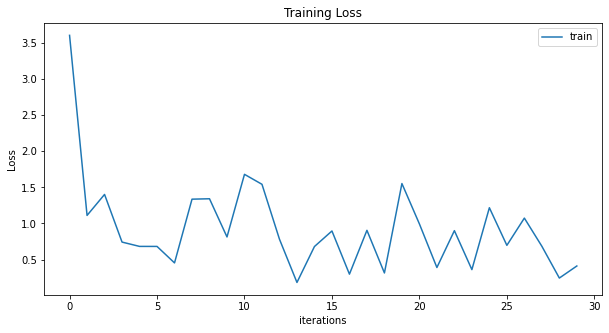

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Training Loss")
plt.plot(train_losses,label="train")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Validation Loss")
plt.plot(val_losses,label="validation")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Training Accuracy")
plt.plot(train_accuracies,label="train")
plt.xlabel("iterations")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Validation Accuracy")
plt.plot(val_accuracies,label="train")
plt.xlabel("iterations")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

### Deleting slicing folder

In [ ]:
shutil.rmtree('/content/drive/MyDrive/team_project/gtzan', ignore_errors=True)

# Testing

In [ ]:
def load_audio_file_segmented(songpath, segment):

  sound = None
  song_tensor, _= ta.load(songpath)
  print(song_tensor.size()[1])

  song_name = songpath.split('/')[-1].split('.')[0]
  root = '/content/drive/MyDrive/team_project/song_to_try/'
  os.makedirs(root+'slices')
  

  if songpath.endswith('.mp3') or songpath.endswith('.MP3'):
      for w in range(0, (((song_tensor.size()[1]//44100)//segment)):
        t1 = segment*(w)*1000
        t2 = segment*(w+1)*1000
        newAudio = AudioSegment.from_mp3(songpath)
        sound = newAudio[t1:t2]
        sound.export(f'/content/drive/MyDrive/team_project/song_to_try/slices/{song_name+str(w)}.mp3', format="mp3")
      newpath = root+'slices/'

  elif songpath.endswith('.wav') or songpath.endswith('.WAV'):
      for w in range(0,((((song_tensor.size()[1]//22050)//segment) ):
        t1 = segment*(w)*1000
        t2 = segment*(w+1)*1000
        newAudio = AudioSegment.from_wav(songpath)
        sound = newAudio[t1:t2]
        sound.export(f'/content/drive/MyDrive/team_project/song_to_try/slices/{song_name+str(w)}.wav', format="wav")
      newpath = root+'slices/' 
    
  return newpath

def get_data(songpath):
  hop_length = 512
  n_fft = 2048
 
  sound_tensor = []

  for _,_,filenames in os.walk(songpath):
    for f in filenames:
      song = os.path.join(songpath,f'{f}')
      y, sr = ta.load(song)
      S = ta.transforms.MelSpectrogram(sample_rate=sr, hop_length=hop_length, n_fft=n_fft)(y) #(channel\ num mels\ time)
      sliced_sound = ta.transforms.AmplitudeToDB(stype='magnitude')(S)
      
      if sliced_sound.size()[0] > 1:
          sliced_sound = torch.unsqueeze(torch.mean(sliced_sound, dim=0), dim=0) # (2, num, time) = (1, num, time) + (1, num, time)

      sound_tensor.append(sliced_sound)
  
  sound_tensor = torch.stack(sound_tensor).to(device)
  return sound_tensor

def predict_song(songpath, segmentSize, model, n_classes, le):
  newpath = load_audio_file_segmented(songpath, segmentSize)
  sound_tensor = get_data(newpath)
  shutil.rmtree(newpath, ignore_errors=True)
  
  model.eval()
  with torch.no_grad():
    class_prediction = []

    predictions = model(sound_tensor)
    class_prediction = [torch.argmax(pred).item() for pred in predictions]
    print(class_prediction)

    p = defaultdict(int)
    for i in class_prediction:
      p[i] += 1
            
    pred_song = max(p.items(), key=lambda x: x[1])[0]
    c = Counter(class_prediction)
    outcomes = [(le.inverse_transform([i])[0], '%.3f'%(c[i] / len(class_prediction) * 100.0)) for i, count in c.most_common()] # [(blues, %), (jazz, %) ...]
    outcomes = outcomes[0:4]
    print(outcomes)
  
  return outcomes

In [ ]:
songpath = '/content/drive/MyDrive/team_project/song_to_try/715.wav'

In [ ]:
preds = predict_song(songpath,3,CRNN,10,le)

## Multi-Classification visualization

In [ ]:
preds_cut = preds[0:4]

others_sum = round(100-(preds[0][1]+preds[1][1]+preds[2][1]), 4)
others = ('others', others_sum)
preds_cut.pop()
preds_cut.append(others)
preds_cut

In [ ]:
import seaborn as sns

plt.rcParams["figure.figsize"] = [7, 4.5]
plt.rcParams["figure.autolayout"] = True
ax = sns.barplot(x=[p[0] for p in preds_cut], y=[float(p[1]) for p in preds_cut], palette='PuBuGn_r')
patches = ax.patches
for i in range(len(patches)):
   x = patches[i].get_x() + patches[i].get_width()/2
   y = patches[i].get_height()+.01
   ax.annotate('{:.2f}%'.format(preds_cut[i][1]), (x, y), ha='center')
plt.show()

### PLOTTING SPECTROGRAMS

In [ ]:
def plot_specgram(waveform, sample_rate, title, xlim=None):
  waveform = waveform.numpy()

  num_channels, num_frames = waveform.shape
  time_axis = torch.arange(0, num_frames) / sample_rate

  figure, axes = plt.subplots(num_channels, 1)
  if num_channels == 1:
    axes = [axes]
  for c in range(num_channels):
    axes[c].specgram(waveform[c], Fs=sample_rate)
    if num_channels > 1:
      axes[c].set_ylabel(f'Channel {c+1}')
    if xlim:
      axes[c].set_xlim(xlim)
  figure.suptitle(title)
  plt.show(block=False)

In [ ]:
song = '/content/drive/MyDrive/team_project/song_to_try/715.wav'
title = 'queen'
y, sr = ta.load(song)
if y.size()[0] > 1:
  y = torch.unsqueeze(torch.mean(y, dim=0), dim=0)

print(f"Shape of spectrogram: {y.size()} with sample rate {sr}")
plot_specgram(y,sr,title)